### Anomaly detection using Gluon

#### 목적 

- Deep Neural Network기반 Anomaly Detection 모델 구축 
- w_shingling 데이터 전처리 기법 소개  

#### Anomaly Detection 

- 클래스 불균형이 매우 큰 문제 
- unsupervised과 supervised 기법이 존재하나 특정 룰을 사용한 unsupervised 기법이 실무에서는 많이 사용됨 
- 최근 센서 데이터가 다양해지며 다변량 데이터를 활용한 Anomaly Detection 기법이 Deep Neural Network 기반으로 사용되는 추세 


#### 데이터 

- NYC taxi passenger count 데이터 


In [239]:
import pandas as pd
import urllib.request
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 300

ds = 'https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv'

In [244]:
taxi_data = pd.read_csv(ds, delimiter=',')

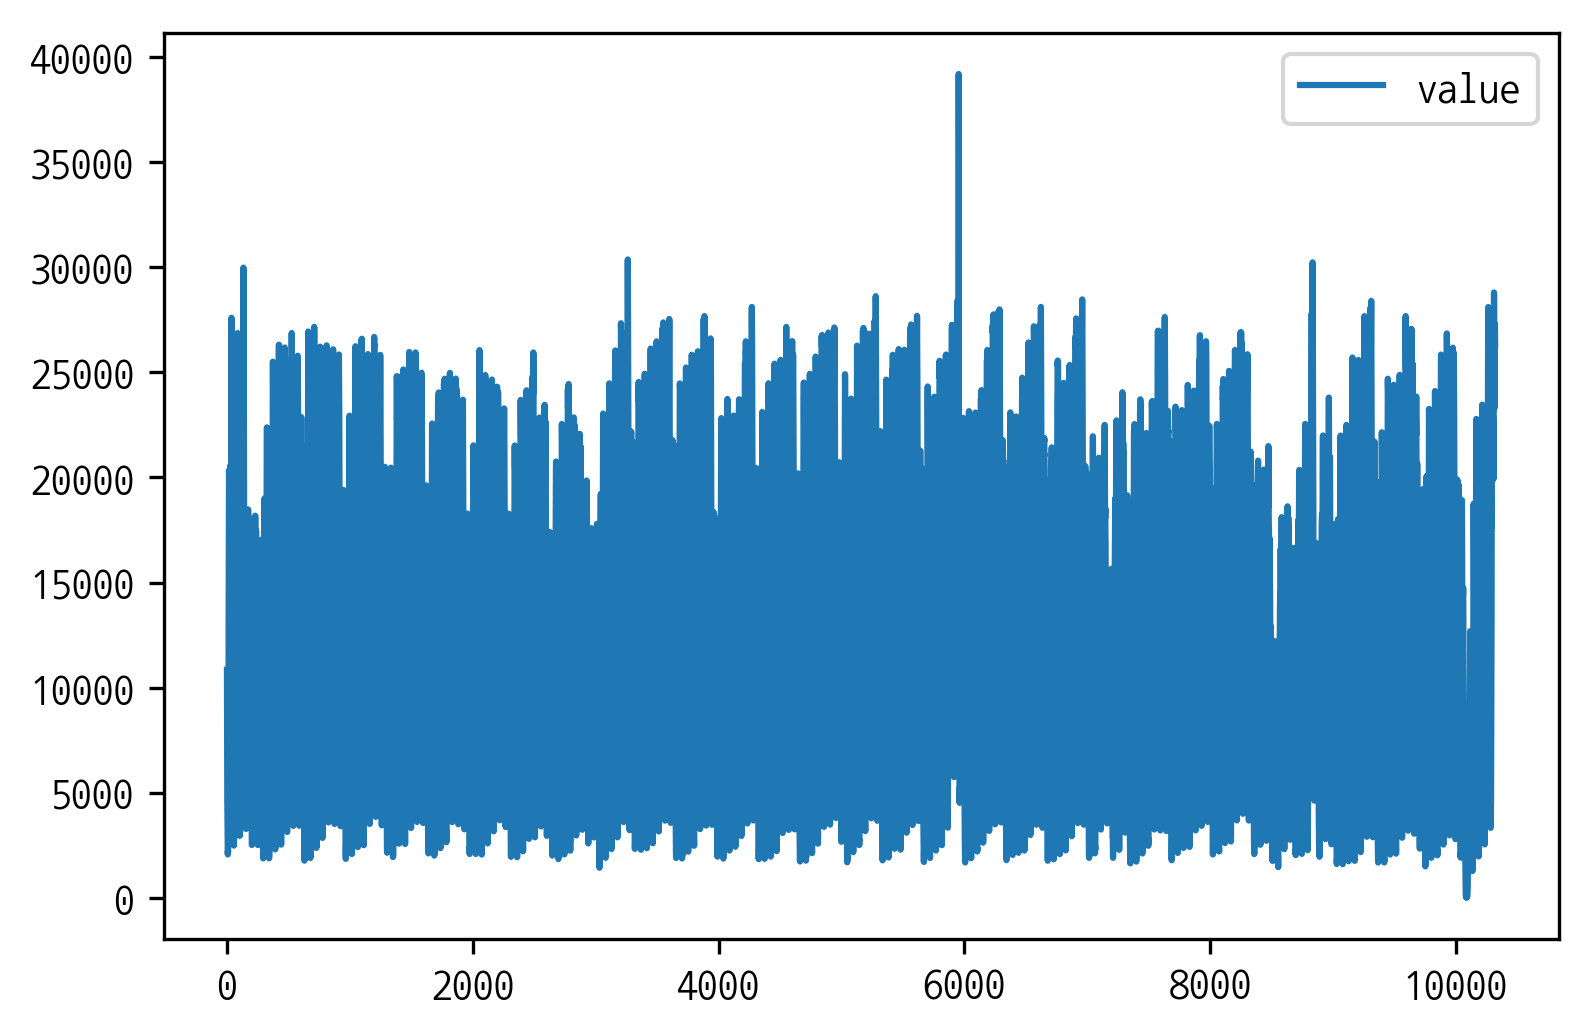

In [241]:
taxi_data.plot()

### 1일, 7일 시즈널 패턴 

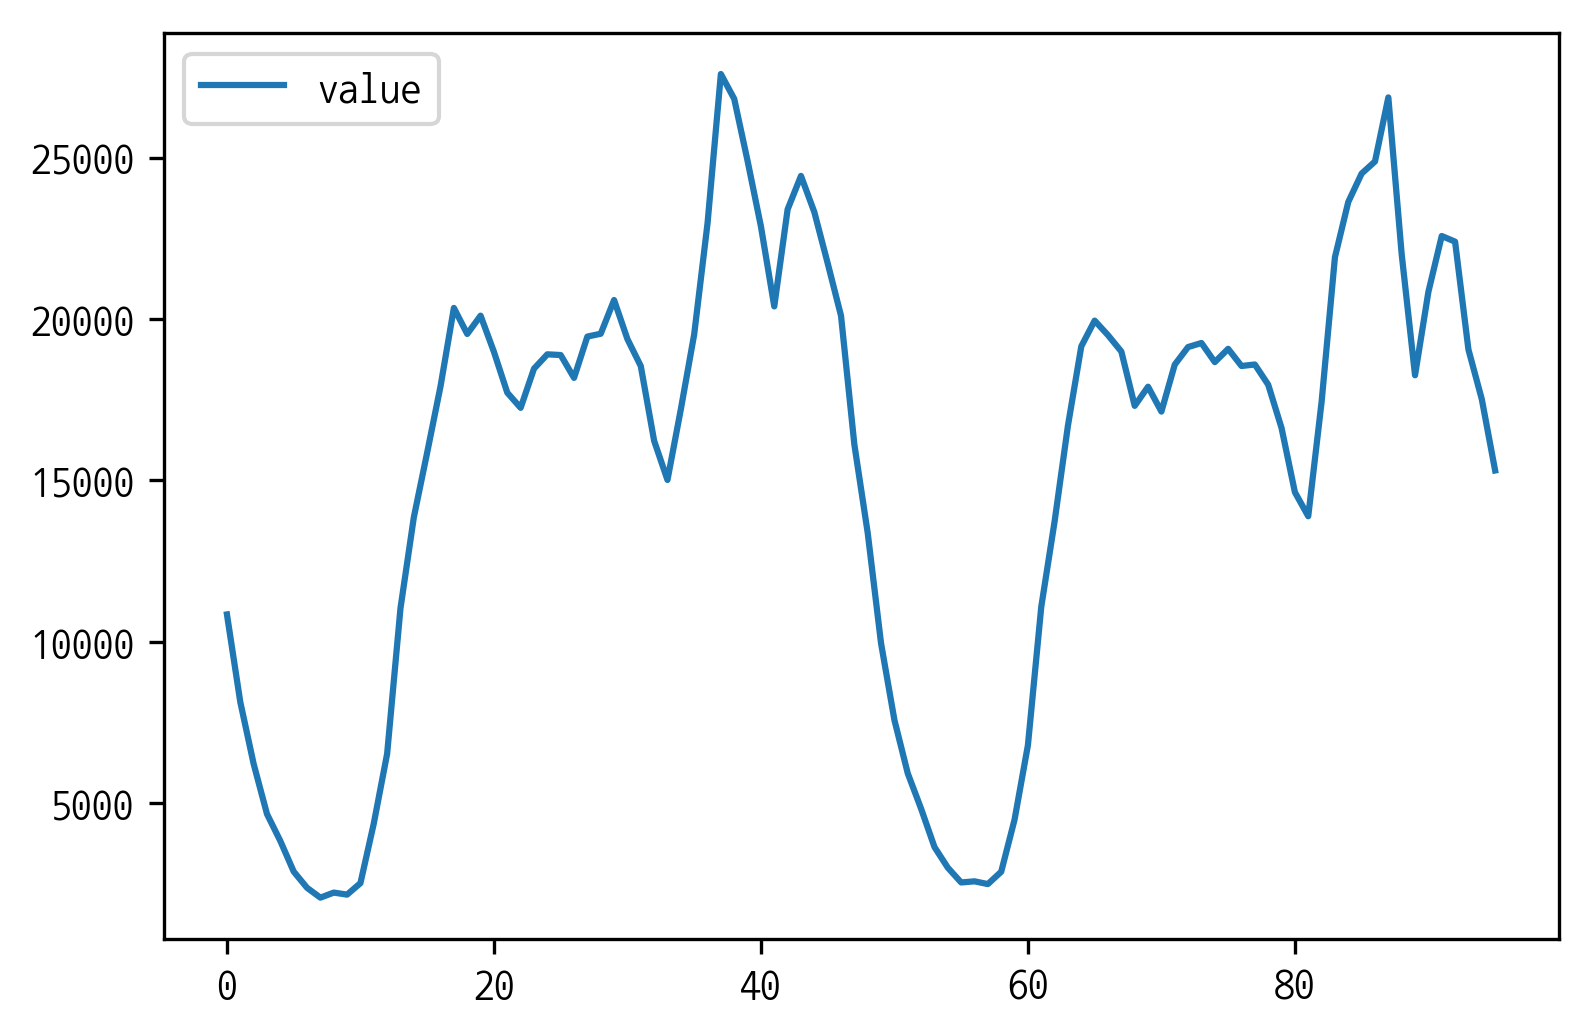

In [247]:
taxi_data[:48*2].plot()

#### 데이터 전처리 

- [w_shingle](https://en.wikipedia.org/wiki/W-shingling) : 일종의 n-gram 전처리 방식
    - 순차 데이터에 대한 학습 효율을 높이기 위한 데이터 처리 방식 

In [249]:
data = taxi_data['value'].as_matrix()
data_z=(data - np.mean(data))/np.std(data)

In [250]:
m = np.mean(data)
st = np.std(data)

In [252]:
def make_shingling_data(data, window):
    shingling = []
    for i in range(len(data)):
        rec = data[(i + 1 - window if i + 1 - window >= 0 else 0):(i+1), ]
        if i + 1 - window < 0:
            rec = np.pad(rec, (window - len(rec),0), 'constant', constant_values=(0, 0))
        shingling.append(rec)
    return(np.array(shingling))

In [270]:
window = 48

data_s = make_shingling_data(data_z, window)

In [271]:
tr_set = data_s[0:int(len(data_s) * 0.85)]
te_set = data_s[int(len(data_s) * 0.85):] 

In [272]:
tr_set.shape, te_set.shape

((8772, 48), (1548, 48))

### 모델 생성 

#### 데이터 로딩 

In [273]:
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn 

In [274]:
batch_size = 50
tr_data = gluon.data.ArrayDataset(tr_set.astype('float32'))
tr_data_iterator = gluon.data.DataLoader(tr_data, batch_size=batch_size, shuffle=False, last_batch ='keep')

te_data = gluon.data.ArrayDataset(te_set.astype('float32'))
te_data_iterator = gluon.data.DataLoader(te_data, batch_size=batch_size, shuffle=False, last_batch ='keep')

#### 모델링 

In [446]:
class TrafficAnomaly(nn.HybridBlock):
    def __init__(self, **kwargs):
        super(TrafficAnomaly, self).__init__(**kwargs)
        with self.name_scope():
            self.seq = nn.HybridSequential()
            self.seq.add(nn.Dense(96, activation='tanh'),
                    nn.Dropout(0.3),
                    nn.Dense(48)
                   )
    
    def hybrid_forward(self,F, inputs):
        return(self.seq(inputs))
            

In [447]:
ctx = mx.gpu(0)

In [448]:
net = TrafficAnomaly()

In [449]:
net

TrafficAnomaly(
  (seq): HybridSequential(
    (0): Dense(None -> 96, Activation(tanh))
    (1): Dropout(p = 0.3)
    (2): Dense(None -> 48, linear)
  )
)

In [450]:
net.initialize(mx.initializer.Xavier(),ctx=ctx)

In [451]:
net(nd.random.normal(0,1,(2,48), ctx=ctx))


[[-0.22300446  0.23337473 -0.4588647  -0.40448403 -0.1246423   0.67480403
  -0.04653826 -0.2983249   0.691266   -1.0149107   0.2605934   0.6313589
  -0.44005924  0.13966517 -0.3857262  -0.22572422  0.19557208  0.19458191
   0.47271153 -0.6451863   0.3071802  -0.8953586   0.13554862  0.05932717
  -0.6796175   0.43297693  0.930801   -0.16283439  0.43070483  0.30463558
  -0.02480308 -0.20388052  0.5321773  -1.9339423   0.1283992  -0.38652623
   0.9163735   0.64872396  0.59022886 -0.18495847  0.48399448  0.63246846
   0.07826416 -0.7479136   0.8430236   0.55164003  0.7650697  -0.08805446]
 [-0.7205924   0.22944325  0.09636971 -0.42618784  0.02999781 -0.2918948
   0.51624805 -1.0539724   0.01661523  1.0608375  -0.15659148 -0.25081939
  -0.74403924 -1.3449645  -0.51361585  0.83318675 -0.09752813 -0.17357069
  -1.1577438   0.51544076 -0.14691925  0.34034586  0.08091374  0.16612396
   0.00610936 -0.71674323  0.24724638  0.9425932   0.10816825  0.1418979
   0.44757557 -0.1751727   0.06475147  

In [452]:
net.hybridize()

In [453]:
trainer = gluon.Trainer(net.collect_params(), 'Adam', {'learning_rate': 0.001})

In [454]:
def evaluate_loss(data_iterator, model):
    loss_avg = 0.
    losses = []
    L = gluon.loss.L2Loss()
    for i, data in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = data
        output = model(data) 
        loss = L(output, label) # Calculate the loss
        losses.append(nd.mean(loss).asscalar())
    return np.mean(losses)

In [455]:
%%time
epochs = 50

all_train_mse = []
all_test_mse = []
L = gluon.loss.L2Loss()

for e in range(epochs):
    for i, data in enumerate(tr_data_iterator):
        data = data.as_in_context(ctx)
        label = data
        with autograd.record():
            output = net(data)
            loss = L(output, label)
            loss.backward()
        trainer.step(data.shape[0])
    
    train_mse = evaluate_loss(tr_data_iterator, net)
    test_mse = evaluate_loss(te_data_iterator, net)
    all_train_mse.append(train_mse)
    all_test_mse.append(test_mse)
    print("train loss : {}, test loss : {}".format(train_mse, test_mse))

train loss : 0.018669189885258675, test loss : 0.0242184828966856
train loss : 0.009887243621051311, test loss : 0.01295494381338358
train loss : 0.007281102705746889, test loss : 0.009749941527843475
train loss : 0.006708801258355379, test loss : 0.009066727012395859
train loss : 0.005621496122330427, test loss : 0.007353081833571196
train loss : 0.004916229750961065, test loss : 0.006539430934935808
train loss : 0.005125462543219328, test loss : 0.00658087944611907
train loss : 0.004651322495192289, test loss : 0.0061279358342289925
train loss : 0.004823770839720964, test loss : 0.006357752252370119
train loss : 0.004908801522105932, test loss : 0.006892751902341843
train loss : 0.005066495854407549, test loss : 0.007013386581093073
train loss : 0.0050809611566364765, test loss : 0.0064121088944375515
train loss : 0.005102604627609253, test loss : 0.006868274416774511
train loss : 0.005589886102825403, test loss : 0.0075189825147390366
train loss : 0.0045766886323690414, test loss : 

In [456]:
def plot_errors(train_mse, test_mse):
    epochs = range(len(train_mse))
    plt.plot(epochs, train_mse, label='Train')
    plt.plot(epochs, test_mse, label='Test')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

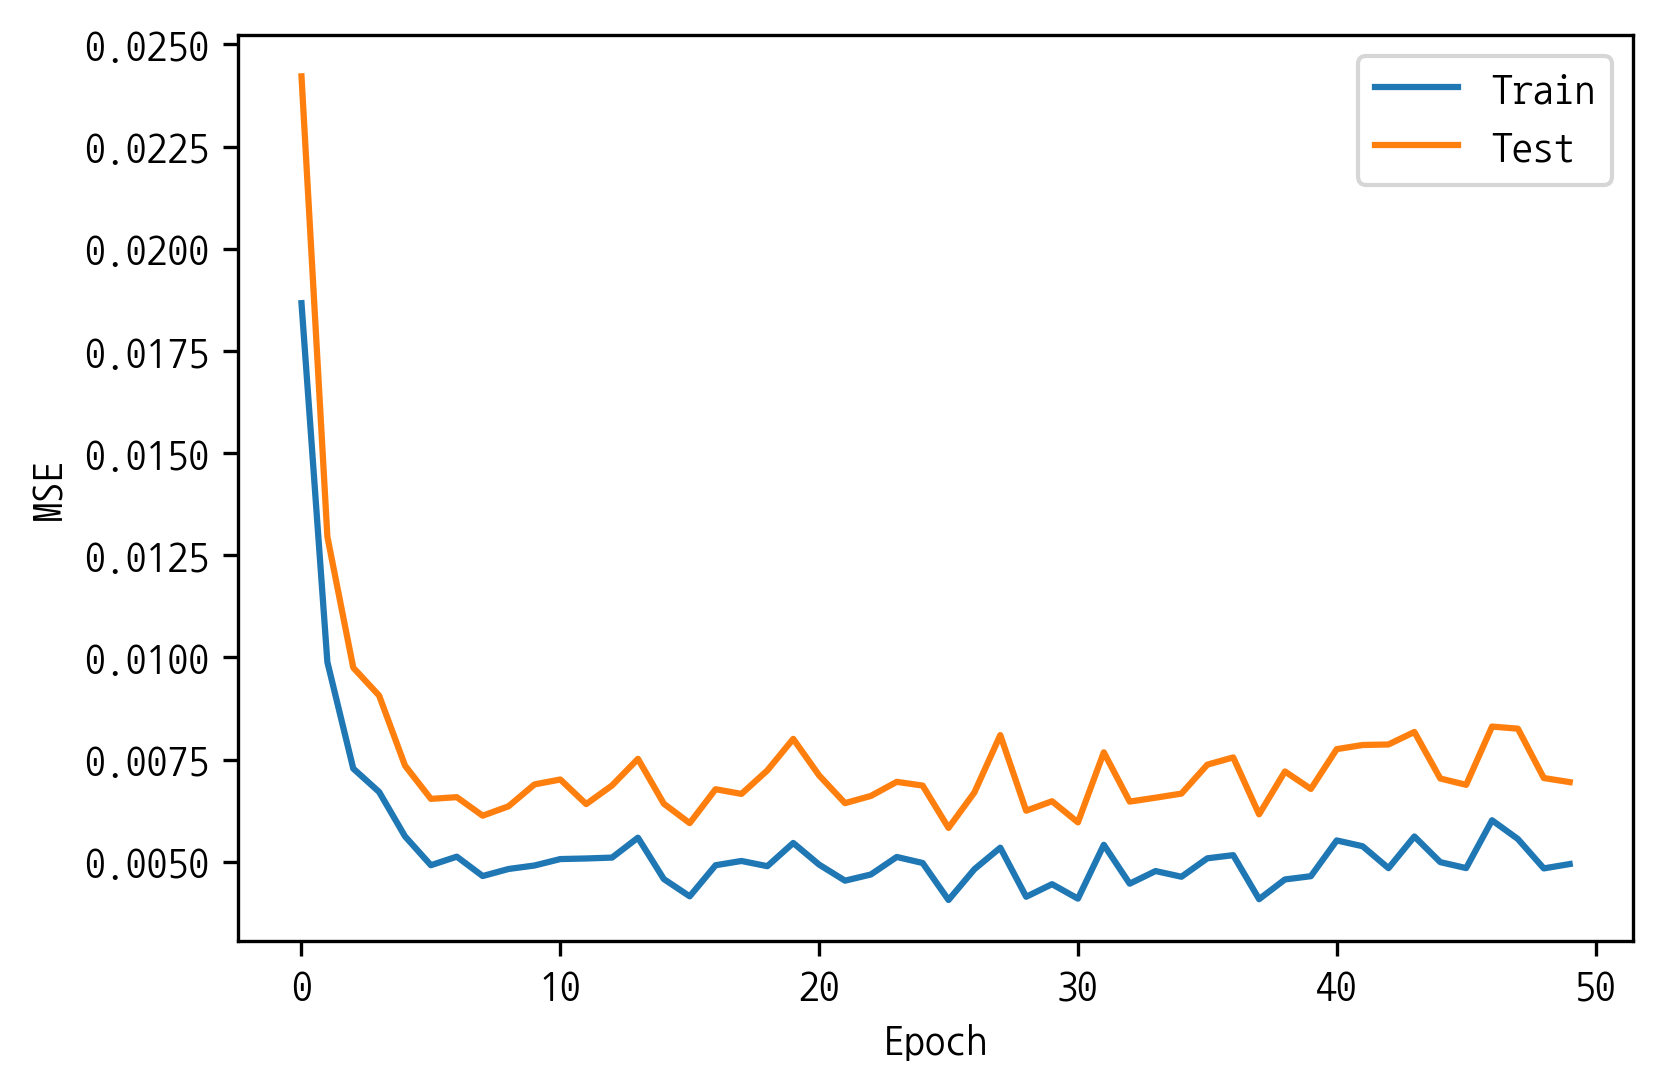

In [457]:
plot_errors(all_train_mse, all_test_mse)

In [458]:
def predict(net, to_predict, L):
    predictions = []
    for i, data in enumerate(to_predict):
        input = data.as_in_context(ctx)
        out = net(input)
        prediction = L(out, input).asnumpy().flatten()
        predictions = np.append(predictions, prediction)
    return predictions

In [459]:
batch_size = 10
data_ad = gluon.data.ArrayDataset(data_z_sp_a.astype('float32'))
data_iter = gluon.data.DataLoader(data_ad, batch_size=batch_size, shuffle=False, last_batch ='keep')

In [460]:
pred = predict(net, data_iter, L)

In [461]:
pred.shape

(215,)

In [462]:
threshold =  np.mean(pred) + 3*np.std(pred)

In [463]:
threshold

0.02095359195462201

In [464]:
te_predictions = predict(net, data_iter, L)

anomaly = list(map(lambda v: v > threshold, te_predictions))

In [465]:
te_data_orig = te_data * st + m

In [466]:
len(anomaly_c)

215

In [467]:
len(data_z_sp_a)

215

In [468]:
np.repeat(anomaly_c, 48)

array(['blue', 'blue', 'blue', ..., 'blue', 'blue', 'blue'], dtype='<U4')

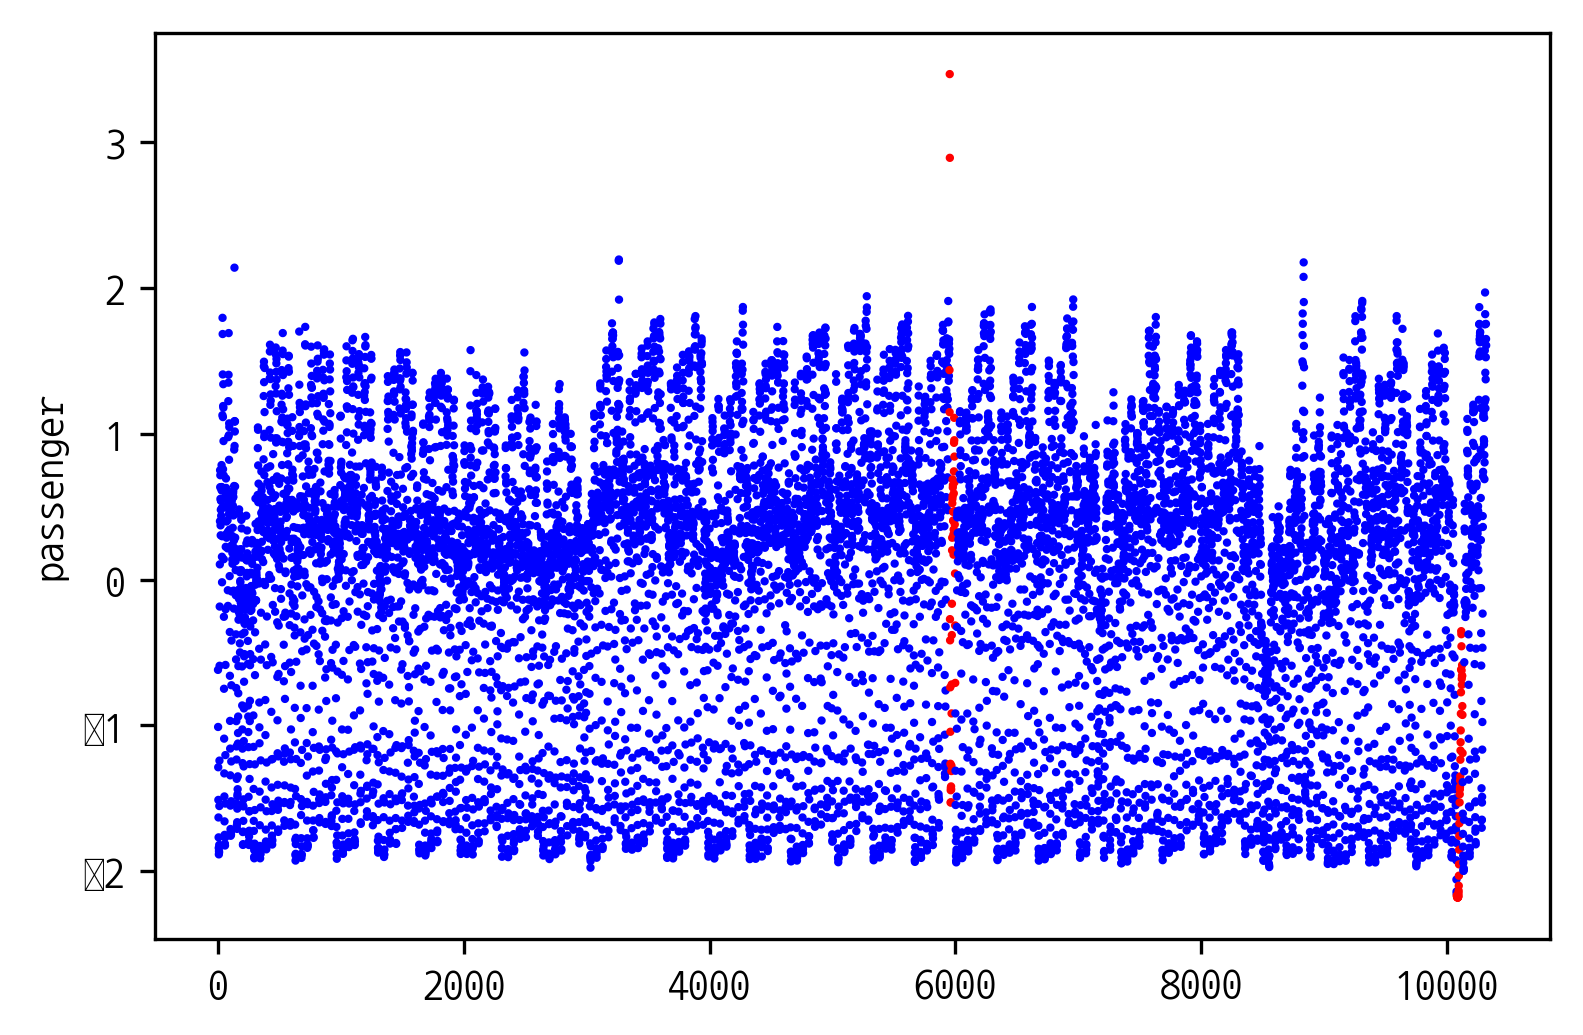

In [469]:
# Result visualization
anomaly_c = list(map(lambda v: "red" if v else "blue", anomaly))
plt.scatter(list(range(len(data_z_sp_a.flatten()))), data_z_sp_a.flatten(), c=np.repeat(anomaly_c, 48), s=1)
plt.ylabel('passenger')
plt.show()

### GRU활용

In [481]:
from mxnet.gluon import rnn

In [482]:
class TrafficAnomalyGru(nn.Block):
    def __init__(self, **kwargs):
        super(TrafficAnomalyGru, self).__init__(**kwargs)
        with self.name_scope():
            self.seq = nn.Sequential()
            self.seq.add(
                    rnn.GRU(10,dropout=0.3),
                    nn.Dense(48)
                   )
    
    def forward(self,inputs):
        ex_inputs = nd.expand_dims(inputs, axis=2)
        return(self.seq(ex_inputs))

In [483]:
gnet = TrafficAnomalyGru()

In [484]:
gnet

TrafficAnomalyGru(
  (seq): Sequential(
    (0): GRU(None -> 30, TNC, dropout=0.3)
    (1): Dense(None -> 48, linear)
  )
)

In [485]:
gnet.initialize(mx.initializer.Xavier(),ctx=ctx)

In [486]:
gnet(nd.random.normal(0,1,(2,48), ctx=ctx)).shape

(2, 48)

In [487]:
gnet

TrafficAnomalyGru(
  (seq): Sequential(
    (0): GRU(1 -> 30, TNC, dropout=0.3)
    (1): Dense(480 -> 48, linear)
  )
)

In [488]:
trainer = gluon.Trainer(gnet.collect_params(), 'Adam', {'learning_rate': 0.001})

In [489]:
%%time
epochs = 30

all_train_mse = []
all_test_mse = []
L = gluon.loss.L2Loss()

for e in range(epochs):
    for i, data in enumerate(tr_data_iterator):
        data = data.as_in_context(ctx)
        label = data
        with autograd.record():
            output = gnet(data)
            loss = L(output, label)
            loss.backward()
        trainer.step(data.shape[0])
    train_mse = evaluate_loss(tr_data_iterator, gnet)
    test_mse = evaluate_loss(te_data_iterator, gnet)
    all_train_mse.append(train_mse)
    all_test_mse.append(test_mse)
    print("train loss : {}, test loss : {}".format(train_mse, test_mse))

train loss : 0.01719825528562069, test loss : 0.01911246031522751
train loss : 0.007320054341107607, test loss : 0.008484568446874619
train loss : 0.00482705095782876, test loss : 0.005571744870394468
train loss : 0.003708172356709838, test loss : 0.004222475457936525
train loss : 0.0030082075390964746, test loss : 0.0033945392351597548
train loss : 0.0025206722784787416, test loss : 0.002834298415109515
train loss : 0.0021537141874432564, test loss : 0.0024204335641115904
train loss : 0.0018577310256659985, test loss : 0.002086696680635214
train loss : 0.0016087632393464446, test loss : 0.0018016959074884653
train loss : 0.0013965046964585781, test loss : 0.0015537445433437824
train loss : 0.001214630901813507, test loss : 0.001338048605248332
train loss : 0.001056540641002357, test loss : 0.0011498391395434737
train loss : 0.0009168332326225936, test loss : 0.0009849539492279291
train loss : 0.0007935721077956259, test loss : 0.0008417231729254127
train loss : 0.0006874747923575342, 

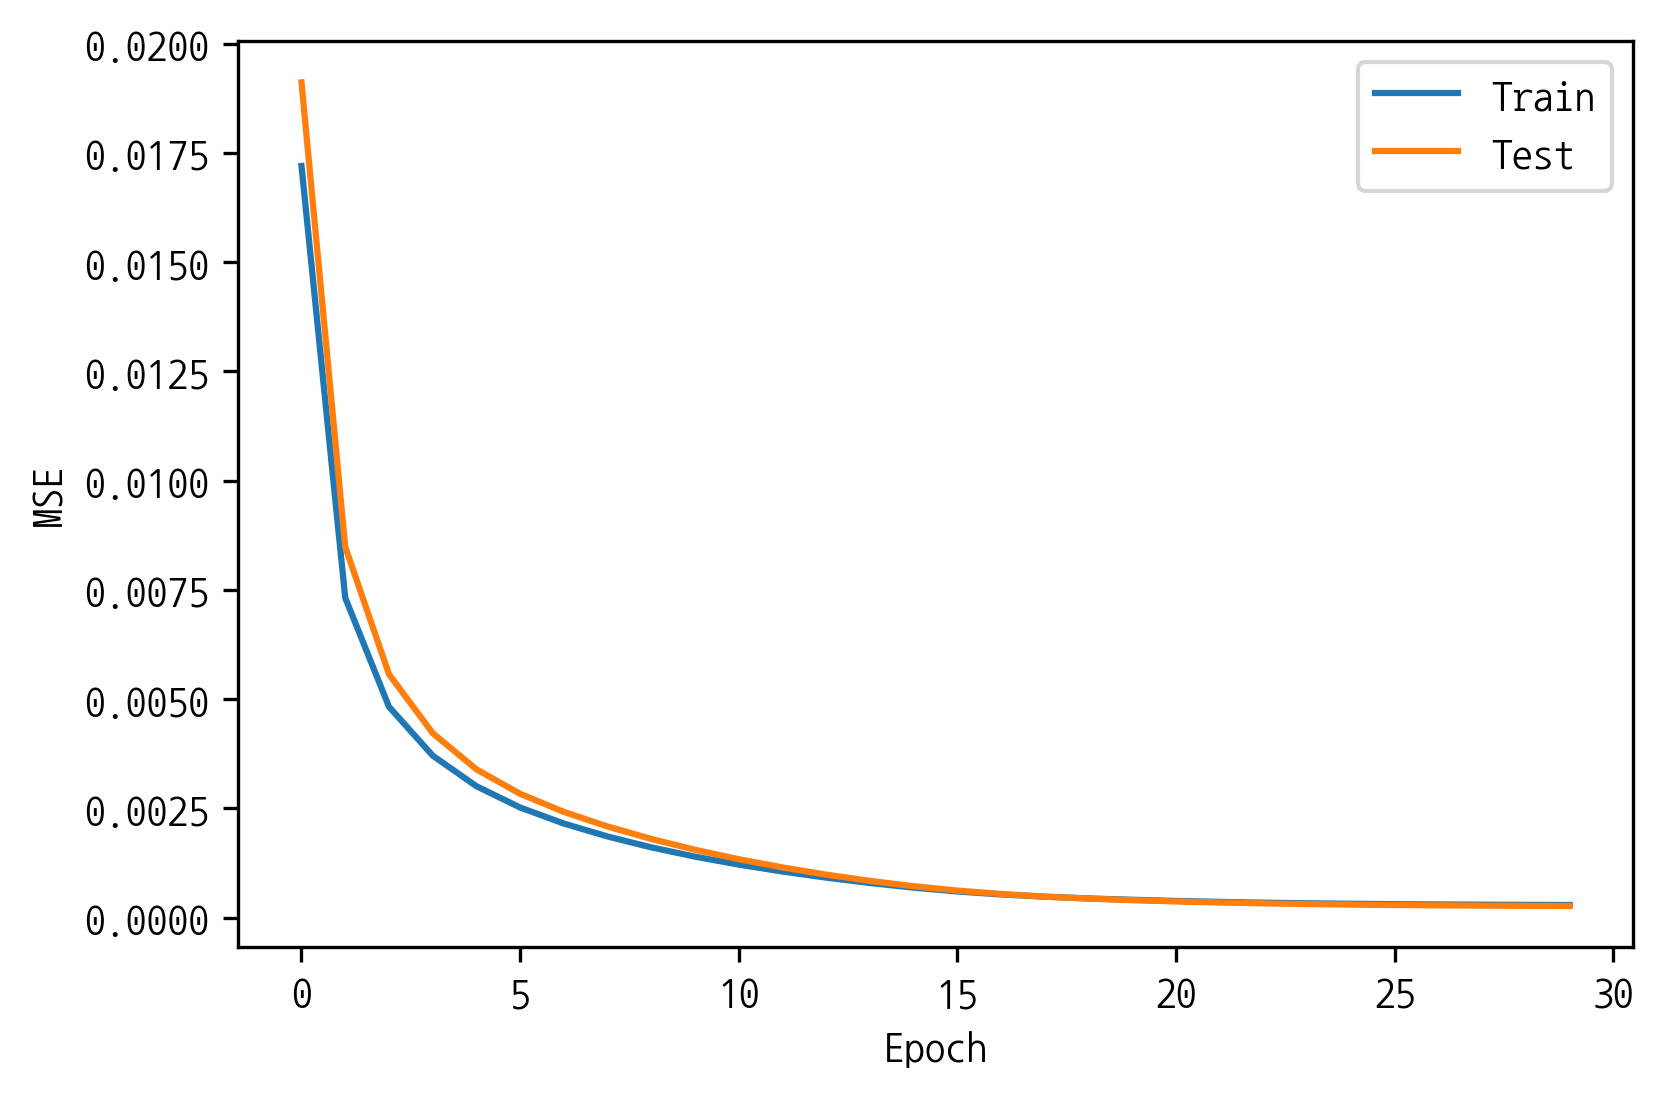

In [491]:
plot_errors(all_train_mse, all_test_mse)

In [492]:
batch_size = 10
data_ad = gluon.data.ArrayDataset(data_z_sp_a.astype('float32'))
data_iter = gluon.data.DataLoader(data_ad, batch_size=batch_size, shuffle=False, last_batch ='keep')

In [493]:
pred = predict(gnet, data_iter, L)

In [494]:
threshold =  np.mean(pred) + 3*np.std(pred)

In [495]:
te_predictions = predict(gnet, data_iter, L)

anomaly = list(map(lambda v: v > threshold, te_predictions))

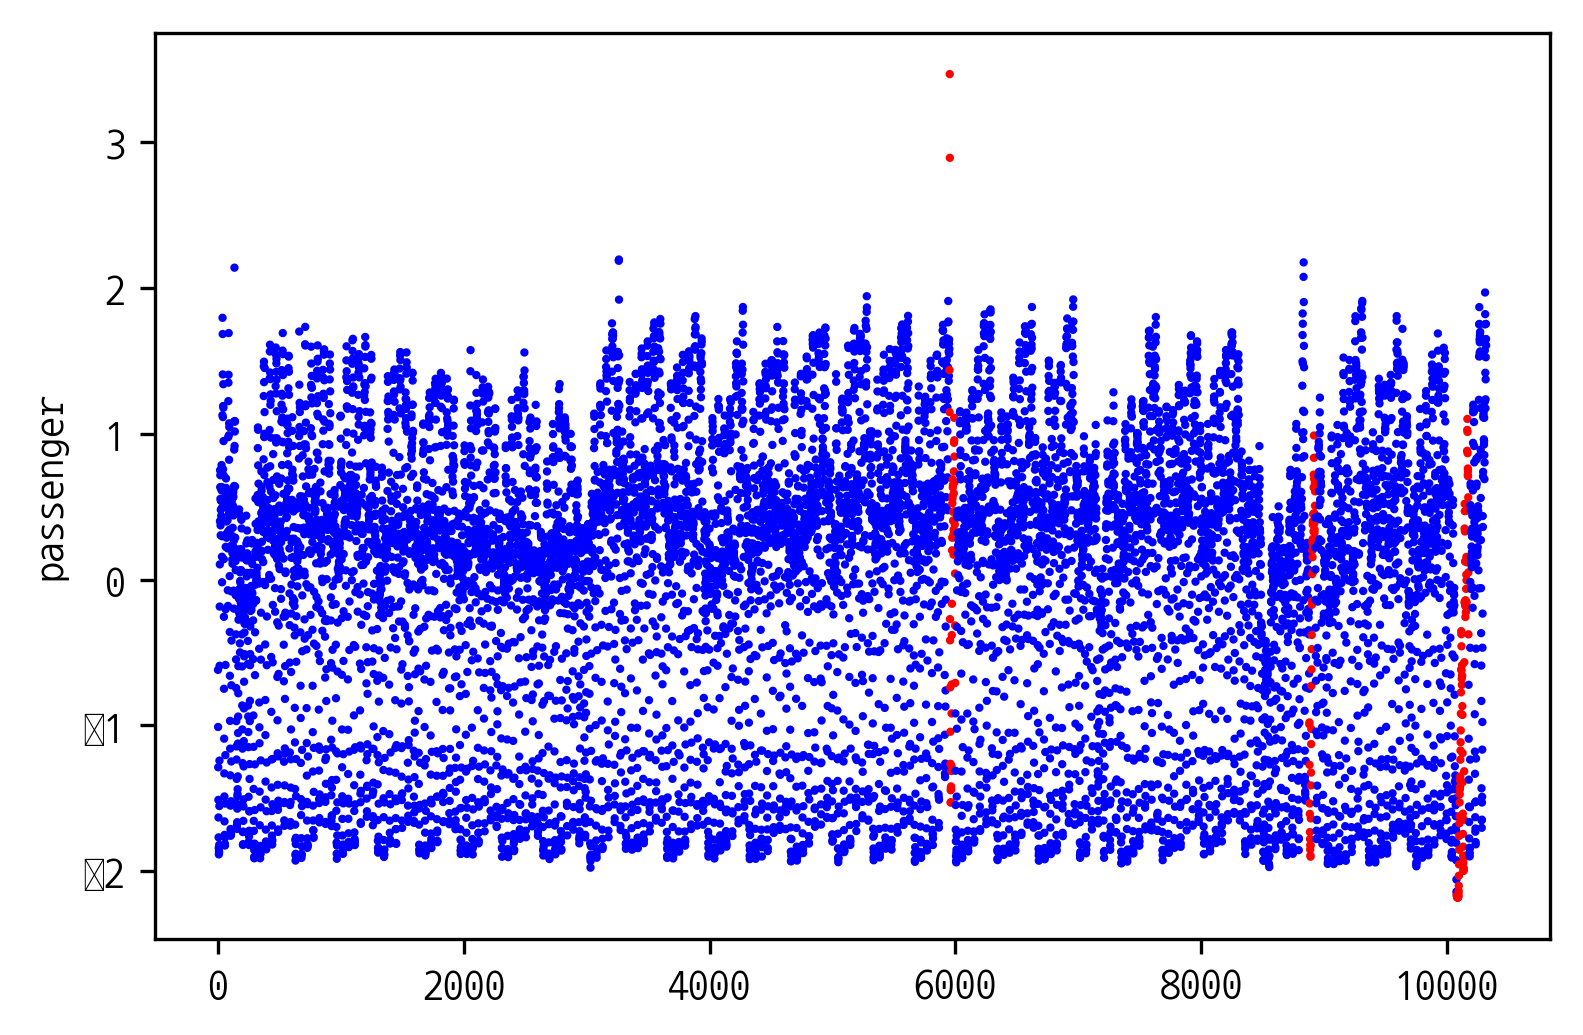

In [497]:
anomaly_c = list(map(lambda v: "red" if v else "blue", anomaly))
plt.scatter(list(range(len(data_z_sp_a.flatten()))), data_z_sp_a.flatten(), c=np.repeat(anomaly_c, 48), s=1)
plt.ylabel('passenger')
plt.show()

#### Reference 

- https://github.com/chickenbestlover/RNN-Time-series-Anomaly-Detection
- https://aws.amazon.com/ko/blogs/machine-learning/use-the-built-in-amazon-sagemaker-random-cut-forest-algorithm-for-anomaly-detection/
- The New York City taxi passenger data stream, provided by the [New
York City Transportation Authority](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml )
- preprocessed (aggregated at 30 min intervals) by Cui, Yuwei, et al. in ["A comparative study of HTM and other neural network models for online sequence learning with streaming data." Neural Networks (IJCNN), 2016 International Joint Conference on. IEEE, 2016.](http://ieeexplore.ieee.org/abstract/document/7727380/)
  , [code](https://github.com/numenta/htmresearch/tree/master/projects/sequence_prediction)